In [117]:
import numpy as np
import os, json
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
#os.listdir(datadir)

In [119]:
def load_behavioral_data(datadir, accuracy_cutoff=0.4):
    df = pd.DataFrame(columns=['subject', 'correct', 'choice', 'image_pair', 'feature_space', 'left_interval', 'right_interval', 'left_sample', 'right_sample', 'center_sample', 'center_interval', 'response', 'RT'])

    feature_spaces = ['pool3-V1', 'pool4-IT']
    image_pairs = ['elephant1_face1', 'horse_cat', 'rocks_leaves', 'grating0_grating90']
    lr_intervals = [0, 100]
    taskkeys = np.array([121,103,106])
    for subj_dir in os.listdir(datadir):
        if 'old' in subj_dir or 'undefined' in subj_dir or '.DS_Store' in subj_dir:
            continue
        subj_files = os.listdir('{}/{}'.format(datadir, subj_dir))
        for subj_file in subj_files:
            with open('{}/{}/{}'.format(datadir, subj_dir, subj_file), 'r') as json_file:
                data = json.load(json_file)
                if 'correct' in data:
                    accuracy = np.nanmean(np.array(data['correct'], dtype=float))
                    nTrials = np.sum(np.logical_not(np.isnan(np.array(data['correct'], dtype=float))))
                    if nTrials < 10:
                        # Run ended prematurely
                        continue
                    if accuracy < accuracy_cutoff:
                        # Accuracy failed to reach cutoff - exclude!
                        continue
                    rows = [pd.Series([subj_dir, data['correct'][i], data['img_choice'][i], image_pairs[data['image_pair'][i]-1], feature_spaces[data['feature_space'][i]-1], 
                                       lr_intervals[data['left_img'][i]-1], lr_intervals[data['right_img'][i]-1], data['left_sample'][i], data['right_sample'][i], 
                                       data['center_sample'][i], data['center_interval'][i], data['response'][i][3], data['RT'][i]], index = df.columns) for i in range(len(data['key']))]
                    df = df.append(rows, ignore_index=True)
    # exclude all nans
    df = df.dropna()
    #df = df[np.logical_not(np.isnan(df['choice']))].reset_index(drop=True)
    df['choice'] = df['choice']-1

    print('Found {} trials across {} subjects'.format(df.shape[0], len(np.unique(df['subject']))))
    trial_params = {'image_pairs': image_pairs, 'feature_spaces': feature_spaces}#{'image_pairs': ['elephant1_face1', 'rocks_leaves'], 'layer': ['pool1', 'pool2', 'pool4'], 'poolsize': ['1x1', '2x2', '3x3', '4x4'], 'sample': [1, 2]}
    
    results = {'data_table': df, 'trial_params': trial_params}
    
    return results

In [120]:
behavior = load_behavioral_data('/Users/akshay/proj/neurint/behavioral_data')
behavior_con = load_behavioral_data('/Users/akshay/proj/neurint/behavioral_data_con')

<ipython-input-119-9842a3f20e92>:16: RuntimeWarning: Mean of empty slice
  accuracy = np.nanmean(np.array(data['correct'], dtype=float))


Found 6811 trials across 89 subjects


<ipython-input-119-9842a3f20e92>:16: RuntimeWarning: Mean of empty slice
  accuracy = np.nanmean(np.array(data['correct'], dtype=float))


Found 6714 trials across 83 subjects


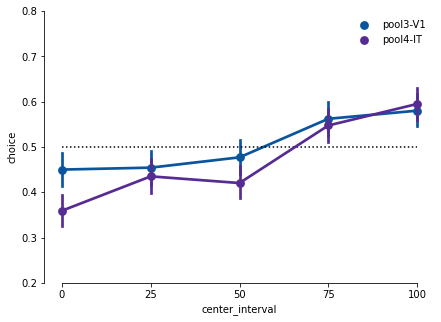

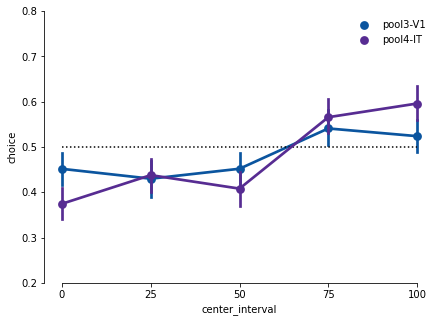

In [121]:
def plot_behavior_response(behavior, hue='image_pair'):
    if hue == 'image_pair':
        hue_order = behavior['trial_params']['image_pairs']
    else:
        hue_order = behavior['trial_params']['feature_spaces']

    palettes = ['Blues', 'Purples']
    df = behavior['data_table']
    #df = df.loc[df['image_pair']!='grating0_grating90']
    if hue == 'feature_space':
        fig,ax = plt.subplots(figsize=(7,5))
        sns.pointplot(data = df, x = 'center_interval', y = 'choice', hue = 'feature_space', 
                  hue_order=hue_order, ax=ax, palette = [sns.color_palette('Blues_r')[0], sns.color_palette('Purples_r')[0]])
        ax.hlines(0.5, 0, 4, ls=':', color='k')
        ax.set_ylim(.2, .8)
        ax.legend(frameon=False)
    else:
        fig,axes = plt.subplots(1,2,figsize=(12,5))

        for fi, feat_space in enumerate(behavior['trial_params']['feature_spaces']):
            ax = axes[fi]
            df_i = df.loc[df['feature_space']==feat_space].reset_index(drop=True)
            sns.pointplot(data = df_i, x = 'center_interval', y = 'choice', hue = hue, 
                          hue_order=hue_order, ax=ax, palette = palettes[fi])
            ax.hlines(0.5, 0, 4, ls=':', color='k')
            ax.set_title(feat_space)
            ax.set_ylim(.2, .8)
            ax.legend(frameon=False)
    sns.despine(trim=True)


plot_behavior_response(behavior, 'feature_space')
plot_behavior_response(behavior_con, 'feature_space')

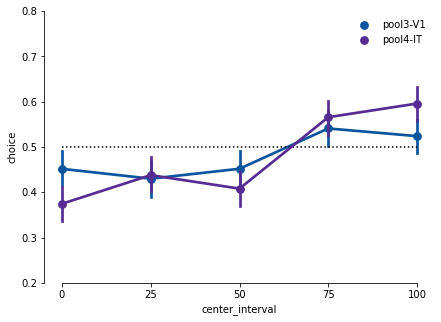

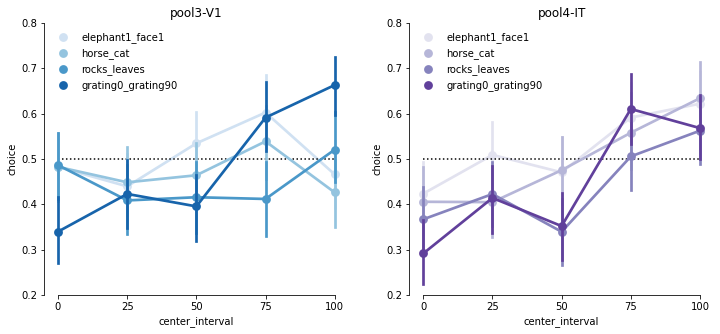

In [123]:
plot_behavior_response(behavior_con, 'feature_space')
plot_behavior_response(behavior_con, 'image_pair')